In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.1.0
TFP version: 0.9.0


# The `DistributionLambda` layer

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import pandas as pd


_ = sns.set_style('whitegrid')

#### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

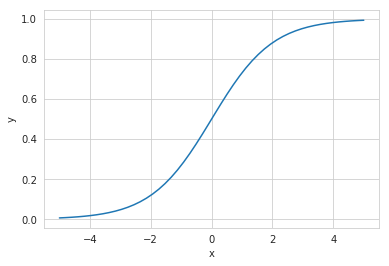

In [6]:
x = np.linspace(start=-5, stop=5)
y = 1 / (np.exp(-x) + 1)

df_plot = pd.DataFrame(zip(x, y), columns=['x', 'y'])
ax = sns.lineplot(x='x', y='y', data=df_plot)

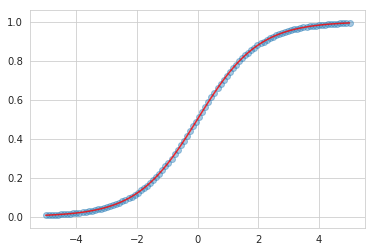

In [7]:
# Create a sigmoid model, first deterministic, then probabilistic

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

In [8]:
# Create a constant input for this model

x = np.array([0])

In [9]:
# Explore the feedforward object...

model.predict(x)

array([[0.5]], dtype=float32)

In [10]:
# ... and its behaviour under repeated calls

for _ in range(10):
    print(model.predict(x))

[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]


As it can be seen, the output value of the model, given the fixed input `x`, is always the same.

#### Use the forward model to create probabilistic training data

The output layer of the model will now be a tfp distribution object.

In [12]:
model = Sequential([
    Dense(
        units=1, # the output will be the `p` Bernoulli param.
        activation='sigmoid', # the sigmoid will make sure `p` is between [0-1]
        input_shape=(1,),
        kernel_initializer=tf.constant_initializer(1),
        bias_initializer=tf.constant_initializer(0)
    ),
    tfpl.DistributionLambda(
        lambda x: tfd.Bernoulli(probs=x),
        convert_to_tensor_fn=tfd.Distribution.sample # specify whats the output of this layer
    )
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



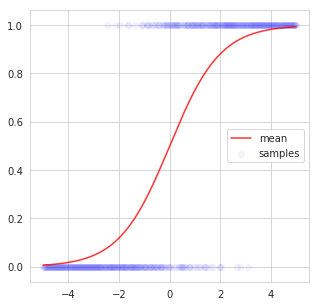

In [16]:
# Use the model to create 500 training points

x_train = np.linspace(-5, 5, 500)[:, np.newaxis]
y_train = model.predict(x_train)

# Plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_train, y_train, alpha=0.04, color='blue', label='samples')
ax.plot(x_train, model(x_train).mean().numpy().flatten(), 
        color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()

In the plot above, we can see the output of the model is not a probability anymore, but a realisation of the Bernoulli random variable (this is because we specified `convert_to_tensor_fn` to sample; if we had otherwise set it to take the mean / mode / etc, it would still output a probability), and thus it takes the value 0 or 1.

#### Create a new probabilistic model with the wrong weights

In [41]:
# Create a new version of the model, with the wrong weights

model_untrained = Sequential([
    Dense(
        units=1, # the output will be the `p` Bernoulli param.
        activation='sigmoid', # the sigmoid will make sure `p` is between [0-1]
        input_shape=(1,),
        kernel_initializer=tf.constant_initializer(2),
        bias_initializer=tf.constant_initializer(2)
    ),
    tfpl.DistributionLambda(
        lambda x: tfd.Bernoulli(probs=x),
        convert_to_tensor_fn=tfd.Distribution.sample # specify whats the output of this layer
    )
])

model_untrained.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_4 (Distr ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


#### Train the new model with the negative loglikelihood

In [42]:
# Define negative loglikelihood, which we will use for training

def nll(y_true: tf.Tensor, y_pred: tfd.Distribution):
    return -y_pred.log_prob(y_true)

In [43]:
# Compile untrained model

model_untrained.compile(loss=nll, optimizer=RMSprop(learning_rate=.01))

In [44]:
# Train model, record weights after each epoch

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in range(100):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

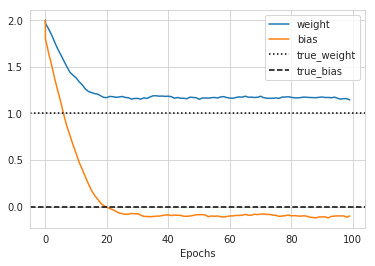

In [45]:
# Plot the model weights as they train, converging to the correct values

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()